In [ ]:
pip install opencv-contrib-python numpy


In [ ]:
from google.colab.patches import cv2_imshow



=== 20JJ_nicowlcam06-2024-09-10-19-36-26.mp4 ===
3×3 csempe RMS értékek:
[[1.25987609 1.52775133 2.64631215]
 [1.41589956 1.28859722 1.49079234]
 [1.24317635 0.54130345 2.0081948 ]]
Globális (ROI-átlag) mozgás RMS: 1.0728


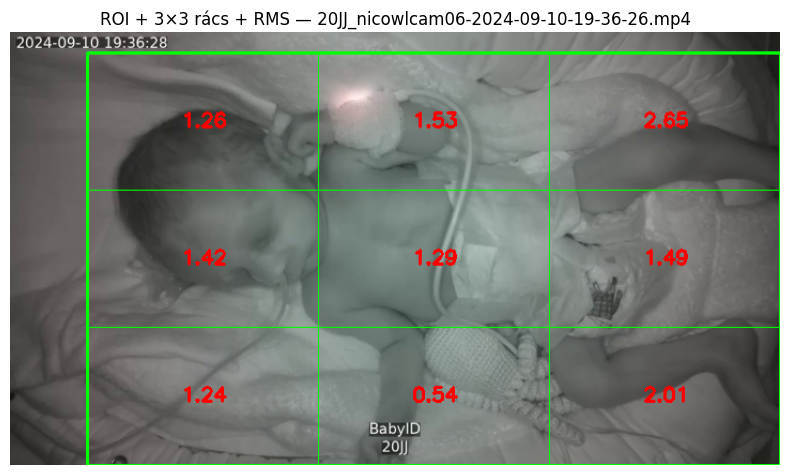

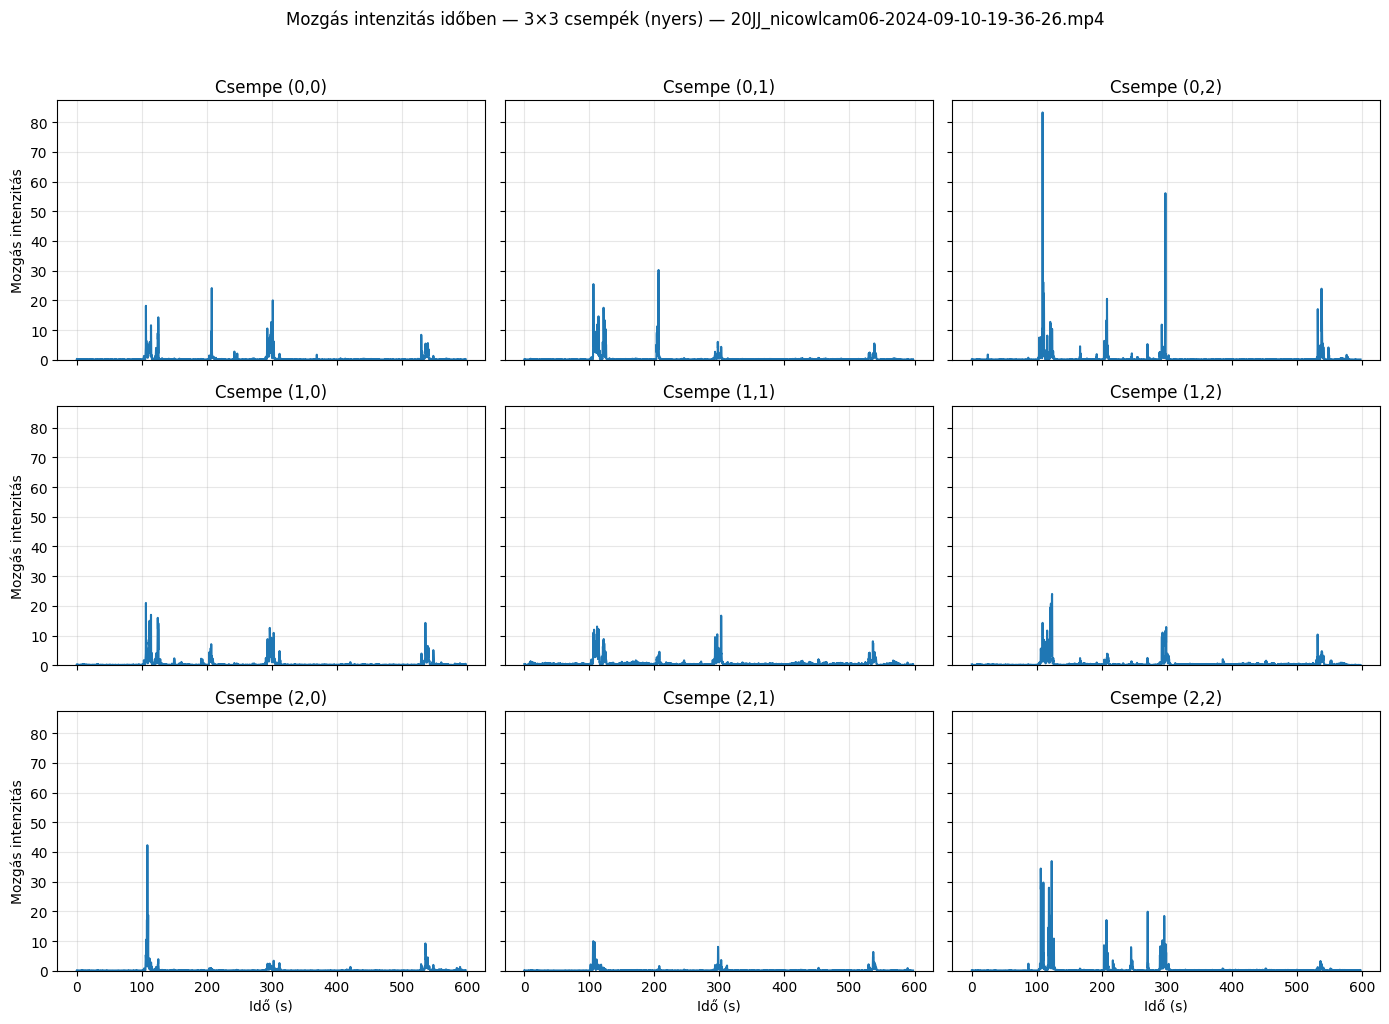

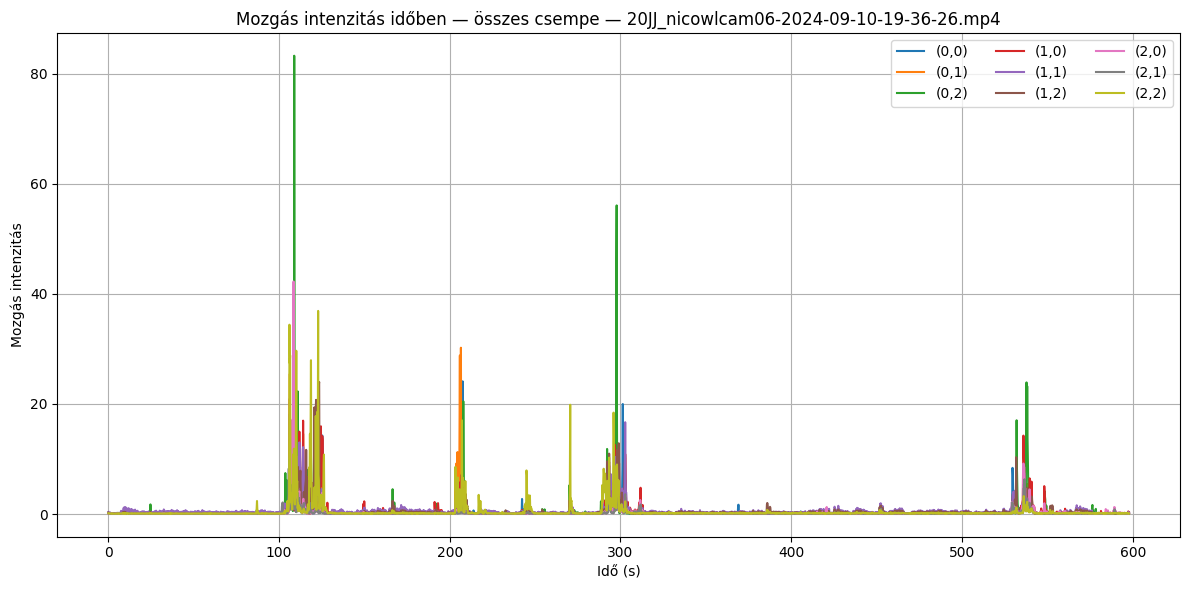

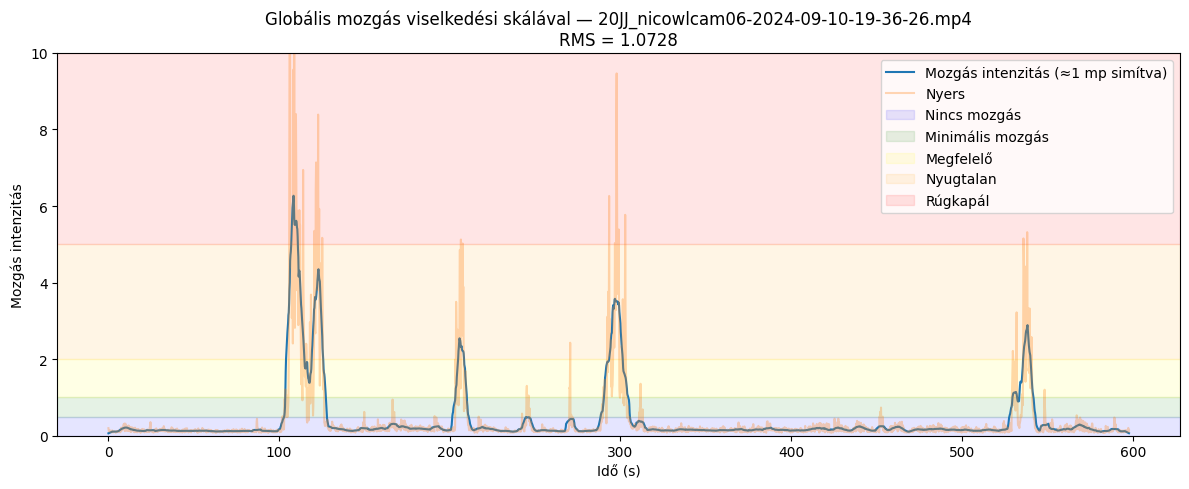

In [ ]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

video_configs = [
    {
        "video_path": "20JJ_nicowlcam06-2024-09-10-19-36-26.mp4",
        "roi": (0.10, 0.05, 1.0, 1.0),
        "tiles_x": 3,
        "tiles_y": 3,
    },

]

frame_step   = 5
target_width = 720
use_roi      = True

def safe_roi_crop(img, roi_rel):
    if not use_roi or roi_rel is None:
        return img
    h, w = img.shape[:2]
    x0 = int(roi_rel[0] * w); y0 = int(roi_rel[1] * h)
    x1 = int(roi_rel[2] * w); y1 = int(roi_rel[3] * h)
    if x1 <= x0: x1 = min(x0 + 1, w)
    if y1 <= y0: y1 = min(y0 + 1, h)
    tile = img[y0:y1, x0:x1].copy()
    if tile.size == 0:
        raise ValueError(f"Üres ROI: {(y1-y0)}x{(x1-x0)}")
    return tile

def draw_roi_grid_with_rms(frame_vis_bgr, roi_rel, tiles_x, tiles_y, tile_rms):
    img = frame_vis_bgr.copy()
    H, W = img.shape[:2]
    if use_roi and roi_rel is not None:
        x0 = int(roi_rel[0]*W); y0 = int(roi_rel[1]*H)
        x1 = int(roi_rel[2]*W); y1 = int(roi_rel[3]*H)
        if x1 <= x0: x1 = min(x0+1, W)
        if y1 <= y0: y1 = min(y0+1, H)
    else:
        x0, y0, x1, y1 = 0, 0, W, H

    cv.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)

    roi_w, roi_h = (x1 - x0), (y1 - y0)
    tile_w_vis = roi_w / tiles_x
    tile_h_vis = roi_h / tiles_y

    for i in range(tiles_y):
        for j in range(tiles_x):
            if j > 0:
                x = int(x0 + j * tile_w_vis)
                cv.line(img, (x, y0), (x, y1), (0, 255, 0), 1)
            if i > 0:
                y = int(y0 + i * tile_h_vis)
                cv.line(img, (x0, y), (x1, y), (0, 255, 0), 1)

            cx = int(x0 + (j + 0.5) * tile_w_vis)
            cy = int(y0 + (i + 0.5) * tile_h_vis)
            val = tile_rms[i, j]
            cv.putText(img, f"{val:.2f}", (cx - 20, cy + 5),
                       cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    return img

def moving_average(x, win):
    if win <= 1 or len(x) <= 1:
        return np.asarray(x, dtype=float)
    win = max(1, int(win))
    if len(x) > win:
        return np.convolve(x, np.ones(win)/win, mode='same')
    else:
        return np.asarray(x, dtype=float)

def process_video(video_path, roi, tiles_x=3, tiles_y=3):
    cap = cv.VideoCapture(video_path)
    ok, frame1 = cap.read()
    if not ok:
        raise RuntimeError(f"Nem sikerült betölteni az első frame-et! ({video_path})")

    fps = cap.get(cv.CAP_PROP_FPS) or 30.0

    h0, w0 = frame1.shape[:2]
    scale = target_width / float(w0)
    new_size = (int(w0 * scale), int(h0 * scale))

    prvs_full = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
    prvs = cv.resize(prvs_full, new_size, interpolation=cv.INTER_AREA)
    prvs = safe_roi_crop(prvs, roi)
    prvs = np.ascontiguousarray(prvs)

    h_roi, w_roi = prvs.shape
    tile_w = w_roi // tiles_x
    tile_h = h_roi // tiles_y

    of = cv.DISOpticalFlow_create(cv.DISOPTICAL_FLOW_PRESET_FAST)

    tile_motion_values = [[[] for _ in range(tiles_x)] for _ in range(tiles_y)]
    motion_values_global = []
    times = []

    frame_idx = 1
    while True:
        for _ in range(frame_step):
            ok, frame2 = cap.read()
            frame_idx += 1
            if not ok:
                break
        if not ok:
            break

        nxt_full = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
        nxt = cv.resize(nxt_full, new_size, interpolation=cv.INTER_AREA)
        nxt = safe_roi_crop(nxt, roi)
        nxt = np.ascontiguousarray(nxt)

        flow = of.calc(prvs, nxt, None)
        mag = np.linalg.norm(flow, axis=2)

        motion_intensity = np.mean(mag) / max(scale, 1e-6)
        motion_values_global.append(motion_intensity)

        for i in range(tiles_y):
            for j in range(tiles_x):
                y0, y1 = i * tile_h, (i + 1) * tile_h
                x0, x1 = j * tile_w, (j + 1) * tile_w
                tile_mag = mag[y0:y1, x0:x1]
                tile_mean = np.mean(tile_mag) / max(scale, 1e-6)
                tile_motion_values[i][j].append(tile_mean)

        times.append((frame_idx - 1) / fps)
        prvs = nxt

    cap.release()

    tile_rms = np.zeros((tiles_y, tiles_x), dtype=float)
    for i in range(tiles_y):
        for j in range(tiles_x):
            vals = np.array(tile_motion_values[i][j], dtype=float)
            if len(vals) > 0:
                tile_rms[i, j] = np.sqrt(np.mean(vals ** 2))

    global_rms = float(np.sqrt(np.mean(np.square(motion_values_global)))) if motion_values_global else float("nan")

    print(f"\n=== {os.path.basename(video_path)} ===")
    print("3×3 csempe RMS értékek:")
    print(tile_rms)
    print(f"Globális (ROI-átlag) mozgás RMS: {global_rms:.4f}")

    frame_vis = cv.resize(frame1, new_size, interpolation=cv.INTER_AREA).copy()
    frame_vis = draw_roi_grid_with_rms(frame_vis, roi, tiles_x, tiles_y, tile_rms)
    plt.figure(figsize=(8, 6))
    plt.imshow(cv.cvtColor(frame_vis, cv.COLOR_BGR2RGB))
    plt.title(f"ROI + {tiles_x}×{tiles_y} rács + RMS — {os.path.basename(video_path)}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    ymax = 1.05 * max([np.max(vals) if len(vals) > 0 else 0
                       for row in tile_motion_values for vals in row] + [1e-9])
    fig, axes = plt.subplots(tiles_y, tiles_x, figsize=(14, 10), sharex=True, sharey=True)
    for i in range(tiles_y):
        for j in range(tiles_x):
            ax = axes[i, j] if tiles_x * tiles_y > 1 else axes
            series = tile_motion_values[i][j]
            L = min(len(times), len(series))
            ax.plot(times[:L], series[:L])
            ax.set_ylim(0, ymax)
            ax.grid(True, alpha=0.3)
            ax.set_title(f"Csempe ({i},{j})")
    for ax in (axes[-1, :] if tiles_y > 1 else [axes]):
        if isinstance(ax, np.ndarray):
            for a in ax: a.set_xlabel("Idő (s)")
        else:
            ax.set_xlabel("Idő (s)")
    for k in range(tiles_y):
        (axes[k, 0] if tiles_x > 1 else axes).set_ylabel("Mozgás intenzitás")
    fig.suptitle(f"Mozgás intenzitás időben — {tiles_x}×{tiles_y} csempék (nyers) — {os.path.basename(video_path)}", y=1.02)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for i in range(tiles_y):
        for j in range(tiles_x):
            series = tile_motion_values[i][j]
            L = min(len(times), len(series))
            plt.plot(times[:L], series[:L], label=f"({i},{j})")
    plt.xlabel("Idő (s)")
    plt.ylabel("Mozgás intenzitás")
    plt.title(f"Mozgás intenzitás időben — összes csempe — {os.path.basename(video_path)}")
    plt.grid(True)
    plt.legend(ncol=3)
    plt.tight_layout()
    plt.show()

    mv = moving_average(motion_values_global, win=int(fps))
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(times, mv, label="Mozgás intenzitás (≈1 mp simítva)")
    if len(motion_values_global) == len(times):
        ax.plot(times, motion_values_global, alpha=0.3, label="Nyers")

    ax.axhspan(0, 0.5, color="blue", alpha=0.1, label="Nincs mozgás")
    ax.axhspan(0.5, 1, color="green", alpha=0.1, label="Minimális mozgás")
    ax.axhspan(1, 2, color="yellow", alpha=0.1, label="Megfelelő")
    ax.axhspan(2, 5, color="orange", alpha=0.1, label="Nyugtalan")
    ax.axhspan(5, 10, color="red", alpha=0.1, label="Rúgkapál")
    ax.set_ylim(0, 10)


    ax.set_xlabel("Idő (s)")
    ax.set_ylabel("Mozgás intenzitás")
    ax.set_title(f"Globális mozgás viselkedési skálával — {os.path.basename(video_path)}\nRMS = {global_rms:.4f}")
    ax.legend()
    plt.tight_layout()
    plt.show()

for cfg in video_configs:
    process_video(
        video_path=cfg["video_path"],
        roi=cfg.get("roi", (0, 0, 1, 1)),
        tiles_x=cfg.get("tiles_x", 3),
        tiles_y=cfg.get("tiles_y", 3),
    )
